In [1]:
from Bio.PDB import PDBList


In [2]:
from Bio.PDB import PDBList

# Create downloader object
pdbl = PDBList()

# List of relevant RNA PDB IDs
pdb_ids = ['1EHZ', '2GDI', '4V9F', '1S72', '2AW4', '1LNG', '2HOJ', '1Y26', '2GIS', '3V2C']

# Download each into your folder
for pdb_id in pdb_ids:
    pdbl.retrieve_pdb_file(pdb_id, pdir='data/rna3db_pdb', file_format='pdb')


Desired structure doesn't exist
Desired structure doesn't exist
Desired structure doesn't exist


In [3]:
!ls data/rna3db_pdb/


pdb1ehz.ent pdb1s72.ent pdb2gdi.ent pdb2hoj.ent
pdb1lng.ent pdb1y26.ent pdb2gis.ent


🔹 2. Parse PDB Files for RNA Sequences & 3D Coordinates

Here's a Python script to extract:

The RNA sequence (based on residues)

The 3D atomic coordinates (for P, C4', etc.)

In [4]:
from Bio.PDB import PDBParser, is_aa
import os

# Folder with downloaded PDBs
pdb_folder = 'data/rna3db_pdb'
parser = PDBParser(QUIET=True)

# Function to parse one file
def parse_rna_structure(pdb_file):
    structure = parser.get_structure("RNA", pdb_file)
    residues = []
    coords = []

    for model in structure:
        for chain in model:
            for res in chain:
                resname = res.get_resname().strip()
                if resname in ['A', 'U', 'G', 'C']:  # Standard RNA bases
                    residues.append(resname)
                    # Get coordinate of P atom (or fallback to C4')
                    if 'P' in res:
                        coords.append(res['P'].coord)
                    elif "C4'" in res:
                        coords.append(res["C4'"].coord)

    return ''.join(residues), coords

# Loop through downloaded files
rna_data = []
for file in os.listdir(pdb_folder):
    if file.endswith('.ent'):
        path = os.path.join(pdb_folder, file)
        seq, coord = parse_rna_structure(path)
        print(f"{file}: {len(seq)} bases, {len(coord)} atoms")
        rna_data.append({'pdb_id': file[3:7], 'sequence': seq, 'coordinates': coord})


pdb1s72.ent: 2871 bases, 2871 atoms
pdb2gdi.ent: 156 bases, 156 atoms
pdb1y26.ent: 71 bases, 71 atoms
pdb2hoj.ent: 78 bases, 78 atoms
pdb2gis.ent: 94 bases, 94 atoms
pdb1lng.ent: 97 bases, 97 atoms
pdb1ehz.ent: 62 bases, 62 atoms


In [8]:
import json

# Convert numpy arrays to lists
rna_data_clean = []

for entry in rna_data:
    coords_as_list = [coord.tolist() for coord in entry['coordinates']]
    
    rna_data_clean.append({
        'pdb_id': entry['pdb_id'],
        'sequence': entry['sequence'],
        'coordinates': coords_as_list
    })

# Save JSON
with open('rna3db_data.json', 'w') as f:
    json.dump(rna_data_clean, f, indent=2)

print("✅ Saved successfully!")



✅ Saved successfully!


Step 4: Convert RNA Sequence + 3D Coordinates into Graph Format\
Convert JSON RNA Structure into a Graph

In [11]:
pip install networkx

  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import json
import numpy as np
import networkx as nx
from scipy.spatial.distance import euclidean

with open("rna3db_data.json") as f:
    data_list = json.load(f)

DIST_THRESHOLD = 12.0

for entry in data_list:
    pdb_id = entry["pdb_id"]
    sequence = entry["sequence"]
    coords = np.array(entry["coordinates"])

    G = nx.Graph()

    # Add nodes
    for i, (nuc, coord) in enumerate(zip(sequence, coords)):
        x, y, z = map(float, coord)
        G.add_node(i, nucleotide=nuc, x=x, y=y, z=z)

    # Sequential edges
    for i in range(len(sequence) - 1):
        G.add_edge(i, i + 1, type="sequential")

    # Spatial edges
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            if euclidean(coords[i], coords[j]) <= DIST_THRESHOLD:
                G.add_edge(i, j, type="spatial")

    nx.write_gexf(G, f"{pdb_id}_graph.gexf")
    print(f"✅ Saved graph for {pdb_id}")


✅ Saved graph for 1s72
✅ Saved graph for 2gdi
✅ Saved graph for 1y26
✅ Saved graph for 2hoj
✅ Saved graph for 2gis
✅ Saved graph for 1lng
✅ Saved graph for 1ehz


Visualize RNA 3D Graph

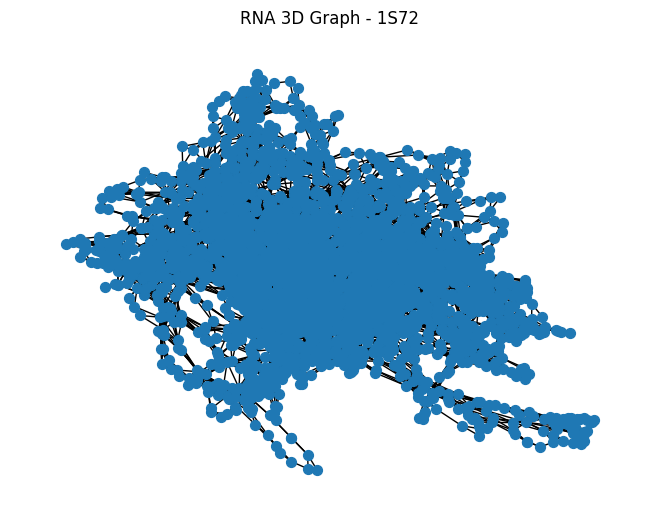

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Load graph
G = nx.read_gexf("1s72_graph.gexf")

# 2D layout
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=50, with_labels=False)
plt.title("RNA 3D Graph - 1S72")
plt.show()


Convert Graphs to PyTorch Geometric Dataset (for GNNs)